# Initialize notebook

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import math
import seaborn as sn
import statistics
from tqdm import tqdm
import time
from functools import partial
from operator import is_not
import pickle
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from math import sqrt

pd.set_option('display.max_columns', None)

In [2]:
# Constants
KITTI_DATASET = '/media/robesafe/SSD_SATA/KITTI_DATASET/'

# Load dataframe and pkl files

In [3]:
df = pd.read_csv (KITTI_DATASET+'kitti_gt.csv')
df_train = pd.read_csv (KITTI_DATASET+'kitti_train_gt.csv')
df_val = pd.read_csv (KITTI_DATASET+'kitti_val_gt.csv')

In [4]:
def objective_const(x, a):
        return a

def objective_log_f(x, a, b, c):
    return a * np.log(x)**b + c

def objective_2f(x, a, b, c):
        return a * x**2 + b * x + c

class Regression_model:
    def __init__(self, function, variables):
        self.function = function
        self.variables = variables
    def __str__(self):
        return "function = %s, variables = %s"%(self.function, self.variables)

class Regression_model_class:
    def __init__(self, model_car, model_pedestrian, model_cyclist):
        self.car = model_car
        self.pedestrian = model_pedestrian
        self.cyclist = model_cyclist
    def __str__(self):
        return "car: {%s},\npedestrian: {%s},\ncyclist: {%s}"%(self.car, self.pedestrian, self.cyclist)
        
class Regression_model_bb:
    def __init__(self, bb_complete, bb_incomplete):
        self.bb_complete = bb_complete
        self.bb_incomplete = bb_incomplete
    def __str__(self):
        return "bb_complete: {%s},\nbb_incomplete: {%s}"%(self.bb_complete, self.bb_incomplete)

In [5]:
height_model = None
pc_proj_refinement_model = None
with open('height_model.pkl', 'rb') as f:
    height_model = pickle.load(f)
with open('pc_proj_refinement_model.pkl', 'rb') as f:
    pc_proj_refinement_model = pickle.load(f)

In [6]:
print(height_model)

car: {bb_complete: {function = <function objective_log_f at 0x7f74ffe4c840>, variables = [689.26985181  -2.0374056  -16.72954044]},
bb_incomplete: {function = <function objective_log_f at 0x7f74ffe4c840>, variables = [651.02767472  -1.7506046  -29.32080446]}},
pedestrian: {function = <function objective_log_f at 0x7f74ffe4c840>, variables = [1173.22871064   -2.52031575  -10.67344022]},
cyclist: {function = <function objective_log_f at 0x7f74ffe4c840>, variables = [1050.87275107   -2.40355944  -12.05918045]}


In [7]:
print(pc_proj_refinement_model)

car: {function = <function objective_2f at 0x7f74ffe4c378>, variables = [-2.18875583e-04  2.37292576e-02  1.23104587e+00]},
pedestrian: {function = <function objective_const at 0x7f74ffe4c598>, variables = [-0.12542462]},
cyclist: {function = <function objective_const at 0x7f74ffe4c598>, variables = [-0.28281803]}


# Execute both models

## Execute height model

In [8]:
def approximate_distance_height(type_name, top, bottom, bb_complete, model):
    height = bottom - top
    if type_name == 'Car':
        if bb_complete:
            f = model.car.bb_complete.function
            return f(height, *model.car.bb_complete.variables)
        else:
            f = model.car.bb_incomplete.function
            return f(height, *model.car.bb_incomplete.variables)
    elif type_name == 'Pedestrian':
        f = model.pedestrian.function
        return f(height, *model.pedestrian.variables)
    elif type_name == 'Cyclist':
        f = model.cyclist.function
        return f(height, *model.cyclist.variables)
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")

In [9]:
df_train['distance_height'] = df_train.apply(lambda row: approximate_distance_height(row['type'],
                                                                              row['top'],
                                                                              row['bottom'],
                                                                              not row['incomplete_2d_horizontal'],
                                                                              height_model), axis=1)
df_val['distance_height'] = df_val.apply(lambda row: approximate_distance_height(row['type'],
                                                                          row['top'],
                                                                          row['bottom'],
                                                                          not row['incomplete_2d_horizontal'],
                                                                          height_model), axis=1)

In [10]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,1.89,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False,8.597865
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,1.67,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False,53.316196
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,1.86,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False,43.396508
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,1.41,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False,36.825652
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False,13.570701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,1.56,1.48,3.36,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False,26.950301
27994,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,1.38,1.55,3.60,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False,48.262606
27995,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,1.35,1.59,3.41,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False,15.359191
27996,5983,11,Car,0.00,2.0,-1.57,594.88,172.76,633.46,207.96,1.52,1.67,3.61,0.16,1.54,33.23,-1.56,33.266050,35.20,38.58,0.01,False,False,35.102942


## Execute pointcloud projection model

In [11]:
def get_point_cloud_projected(image_id):
    name = '%06d'%image_id # 6 digit zeropadding
    img = KITTI_DATASET+'images/'+name+'.png'
    binary = KITTI_DATASET+'velodyne/'+name+'.bin'
    with open(KITTI_DATASET+'calib/'+name+'.txt','r') as f:
        calib = f.readlines()

    # P2 (3 x 4) for left eye (intrinsic matrix in homogeneous coordinates)
    P2 = np.matrix([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3,4)
    R0_rect = np.matrix([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)
    # Add a 1 in bottom-right, reshape to 4 x 4
    R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
    R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
    Tr_velo_to_cam = np.matrix([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
    Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

    # read raw data from binary
    scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))
    points = scan[:, 0:3] # lidar xyz (front, left, up)
    # TODO: use fov filter? 
    velo = np.insert(points,3,1,axis=1).T
    velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
    
    cam = P2 * R0_rect * Tr_velo_to_cam * velo
    cam = np.delete(cam,np.where(cam[2,:]<0)[1],axis=1)
    # get u,v,z
    cam[:2] /= cam[2,:]
    png = mpimg.imread(img)
    IMG_H,IMG_W,_ = png.shape
    # filter point out of canvas
    u,v,z = cam
    u_out = np.logical_or(u<0, u>IMG_W)
    v_out = np.logical_or(v<0, v>IMG_H)
    outlier = np.logical_or(u_out, v_out)
    cam = np.delete(cam,np.where(outlier),axis=1)
    return cam

In [12]:
def get_bounding_boxes_2D(image_id):
    df_frame = df[df['frame'] == image_id]
    bbs = []
    for index, row in df_frame.iterrows():
        bb = (row['left'], row['top'], row['right'], row['bottom'])
        bbs.append(bb)
    return bbs

In [13]:
def approximate_distance_pc(image_id, model):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    types = df[df['frame'] == image_id]['type'].tolist()
    incomplete = df[df['frame'] == image_id]['incomplete_2d_horizontal'].tolist()
    
    
    # Sort bbs by height (change to sort by regression method using height)
    with open('height_model.pkl', 'rb') as f:
        height_model = pickle.load(f)
        id_bbs = sorted(list(range(len(bbs))),
                     key=lambda i: approximate_distance_height(types[i], bbs[i][1], bbs[i][3],
                                                        not incomplete[i], height_model))
        bbs = list(enumerate(bbs))
        types = list(enumerate(types))
        bbs.sort(key=lambda x: id_bbs.index(x[0]))
        types.sort(key=lambda x: id_bbs.index(x[0]))
        bbs = list(map(lambda x: x[1], bbs))
        types = list(map(lambda x: x[1], types))
        
    # Create output dict
    bbs_distance = {'frame':[image_id]*len(types),
                    'left':list(map(lambda x: x[0], bbs)),
                    'top':list(map(lambda x: x[1], bbs)),
                    'right':list(map(lambda x: x[2], bbs)),
                    'bottom':list(map(lambda x: x[3], bbs)),
                    'type':types,
                    'distance':[]}    
    
    # Iterate over bb
    for type_name, bb in zip(types, bbs):
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            # Approximate distance
            distance = np.median(np.squeeze(np.asarray(pc_distance_bb)))
            height = bb[3] - bb[1] # bottom - top
            if type_name == 'Car':
                f = model.car.function
                rectification = f(distance, *model.car.variables)
                distance += rectification
            elif type_name == 'Pedestrian':
                f = model.pedestrian.function
                rectification = f(distance, *model.pedestrian.variables)
                distance += rectification
            elif type_name == 'Cyclist':
                f = model.cyclist.function
                rectification = f(distance, *model.cyclist.variables)
                distance += rectification
            else:
                print("Type must be Car, Pedestrian or Cyclist")
            
            bbs_distance['distance'].append(distance)
        else:
            bbs_distance['distance'].append(None)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_distance

In [14]:
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
distance_approx = {'frame':[], 'left':[], 'top':[], 'right':[], 'bottom':[], 'type':[], 'distance':[]}
for frame in df['frame'].unique():
    frame_approx = approximate_distance_pc(frame, pc_proj_refinement_model)
    dict_items = ['frame','left','top','right','bottom','type','distance']
    for item in dict_items:
        distance_approx[item].extend(frame_approx[item])
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = dict_items[:-1]+['distance_pointcloud'],
                         data = list(zip(distance_approx['frame'], distance_approx['left'],
                                         distance_approx['top'], distance_approx['right'],
                                         distance_approx['bottom'], distance_approx['type'],
                                         distance_approx['distance'])))

100%|█████████▉| 7479/7481 [02:43<00:00, 40.72it/s]

In [15]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom','type'],
                  right_on=['frame','left','top','right','bottom','type'])

In [16]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud
0,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,1.49,1.46,3.84,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,35.735784
1,5984,1,Pedestrian,0.0,1.0,2.84,759.60,163.84,772.27,193.28,1.86,0.57,1.08,9.91,1.30,46.20,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,46.292605
2,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,2.21,1.76,4.11,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,50.873979
3,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,1.75,1.57,4.07,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,52.218798
4,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,1.54,1.71,5.03,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,53.655013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,1.77,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False,18.821832,20.637356
6854,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,1.49,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False,29.010171,26.912365
6855,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,1.48,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False,31.921166,31.300070
6856,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,1.41,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False,35.686282,32.021300


# Analyze model error as dependent on attributes

In [17]:
df_train['error_distance_height'] = df_train['distance'] - df_train['distance_height']
df_val['error_distance_height'] = df_val['distance'] - df_val['distance_height']
df_train['error_distance_pointcloud'] = df_train['distance'] - df_train['distance_pointcloud']
df_val['error_distance_pointcloud'] = df_val['distance'] - df_val['distance_pointcloud']

In [18]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,1.89,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False,8.597865,12.254393,0.135668,-3.520860
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,1.67,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False,53.316196,58.681781,7.511702,2.146117
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,1.86,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False,43.396508,45.473034,2.691626,0.615100
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,1.41,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False,36.825652,35.513878,-2.224356,-0.912582
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False,13.570701,13.763681,-0.197934,-0.390914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27993,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,1.56,1.48,3.36,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False,26.950301,41.908662,-1.439345,-16.397705
27994,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,1.38,1.55,3.60,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False,48.262606,43.478792,-4.763836,0.019978
27995,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,1.35,1.59,3.41,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False,15.359191,8.980264,-1.610715,4.768212
27996,5983,11,Car,0.00,2.0,-1.57,594.88,172.76,633.46,207.96,1.52,1.67,3.61,0.16,1.54,33.23,-1.56,33.266050,35.20,38.58,0.01,False,False,35.102942,NaN,-1.836891,NaN


## Analyze height model error

### Error base on approximate distance

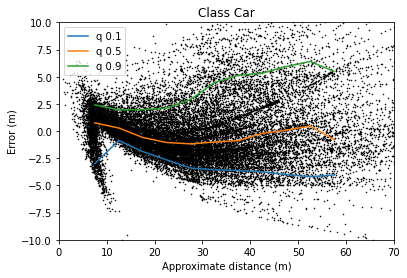

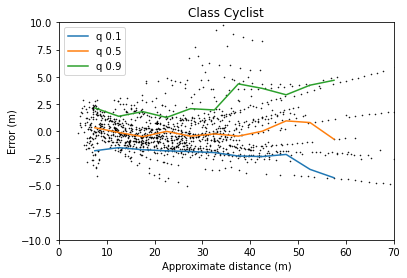

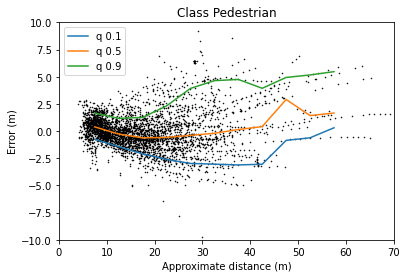

In [19]:
jump = 5
start = 5
end = 60

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train_class[(distance < df_train_class['distance_height']) & \
                                           (df_train_class['distance_height'] < distance+jump)].apply(lambda row: row['distance']-row['distance_height'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_1 = list(map(lambda x: x.get(0.1), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_9 = list(map(lambda x: x.get(0.9), MDistanceE_distances))

    Y = df_train_class['error_distance_height'].values
    X = df_train_class['distance_height'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,70))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

### Error base on height

In [20]:
print(min(df['height_image']))
print(max(df['height_image']))

12.670000000000016
334.53


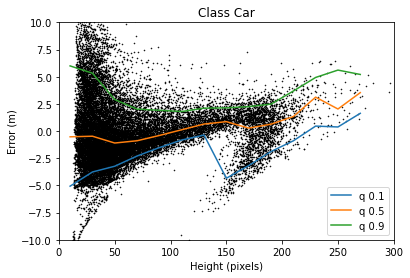

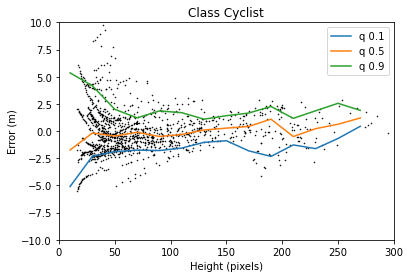

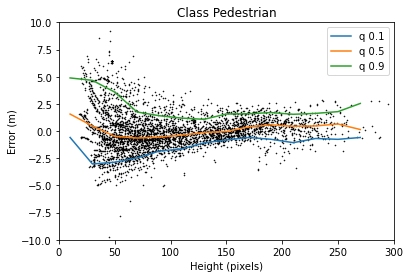

In [21]:
jump = 20
start = 0
end = 280

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MHeightE_heigths = []
    for height in range(start, end, jump):
        MHeightE_heigth = df_train_class[(height < df_train_class['height_image']) & \
                                           (df_train_class['height_image'] < height+jump)].apply(lambda row: row['distance']-row['distance_height'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MHeightE_heigths.append(MHeightE_heigth)
    q_0_1 = list(map(lambda x: x.get(0.1), MHeightE_heigths))
    q_0_5 = list(map(lambda x: x.get(0.5), MHeightE_heigths))
    q_0_9 = list(map(lambda x: x.get(0.9), MHeightE_heigths))

    Y = df_train_class['error_distance_height'].values
    X = df_train_class['height_image'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Height (pixels)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,300))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

## Analyze pointcloud model error

In [22]:
def get_n_points_pc_projection_without_intersections(image_id):
    bbs = get_bounding_boxes_2D(image_id)
    projected_pc = get_point_cloud_projected(image_id)
    
    bbs_n_points = [[],[]]
    # Sort bbs by height
    bbs = sorted(bbs, key=lambda bb: bb[3]-bb[1], reverse=True)
    # Iterate over bb
    for bb in bbs:
        filter_bb = (bb[0] < projected_pc[0,:]) & (bb[1] < projected_pc[1,:]) &\
            (projected_pc[0,:] < bb[2]) & (projected_pc[1,:] < bb[3])
        pc_distance_bb = projected_pc[2,:][filter_bb]
        
        if pc_distance_bb.size != 0: # Checks if there's any point on the bb 2D
            bbs_n_points[0].append(bb)
            bbs_n_points[1].append(pc_distance_bb.size)
        
        # Removing points from the pointcloud in the bb
        filter_intersection = (bb[0] < projected_pc[0,:]) &\
                       (bb[1] < projected_pc[1,:]) &\
                       (projected_pc[0,:] < bb[2]) &\
                       (projected_pc[1,:] < bb[3])
        projected_pc = np.concatenate((projected_pc[0,:][~filter_intersection],\
                                       projected_pc[1,:][~filter_intersection],\
                                       projected_pc[2,:][~filter_intersection]), axis=0)
    
    return bbs_n_points

In [23]:
frame_list, left_list, top_list, right_list, bottom_list, n_points_list = [], [], [], [], [], []
loading_bar = tqdm(total=len(df['frame'].unique()), position=0, leave=True)
# Iterate over frames
for frame in df['frame'].unique():
    # Get distance approimation using 2nd method
    bbs2D, n_points = get_n_points_pc_projection_without_intersections(frame)
    # Fill columns data in lists
    frame_list.extend(len(n_points)*[frame])
    ## Iterate over bbs2D
    for bb2D in bbs2D:
        left_list.append(bb2D[0])
        top_list.append(bb2D[1])
        right_list.append(bb2D[2])
        bottom_list.append(bb2D[3])
    n_points_list.extend(n_points)
    
    loading_bar.update(1)
df_approx = pd.DataFrame(columns = ['frame','left','top','right','bottom','n_points'],
                         data = list(zip(frame_list, left_list, top_list, right_list, bottom_list, n_points_list)))

100%|██████████| 7481/7481 [02:32<00:00, 42.55it/s]

In [24]:
df_approx

,frame,left,top,right,bottom,n_points
0,0,712.40,143.00,810.73,307.92,1463
1,1,676.60,163.95,688.98,193.93,27
2,1,387.63,181.54,423.81,203.12,12
3,2,657.39,190.13,700.07,223.39,111
4,3,614.24,181.78,727.31,284.77,1016
...,...,...,...,...,...,...
34010,7480,501.01,178.40,523.53,228.03,112
34011,7480,344.07,180.05,479.10,224.15,380
34012,7480,382.70,179.71,495.48,219.10,56
34013,7480,631.71,179.85,678.40,214.37,121


In [25]:
df_train = pd.merge(df_train, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])
df_val = pd.merge(df_val, df_approx,  how='inner',
                  left_on=['frame','left','top','right','bottom'],
                  right_on=['frame','left','top','right','bottom'])

In [26]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud,n_points
0,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,1.49,1.46,3.84,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,35.735784,-1.989883,-0.502135,228
1,5984,1,Pedestrian,0.0,1.0,2.84,759.60,163.84,772.27,193.28,1.86,0.57,1.08,9.91,1.30,46.20,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,46.292605,3.544160,0.976181,27
2,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,2.21,1.76,4.11,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,50.873979,14.057587,-0.028144,50
3,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,1.75,1.57,4.07,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,52.218798,6.600798,0.493278,18
4,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,1.54,1.71,5.03,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,53.655013,2.502564,-0.070957,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6696,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,1.77,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False,18.821832,20.637356,0.954502,-0.861021,449
6697,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,1.49,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False,29.010171,26.912365,-1.965325,0.132481,380
6698,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,1.48,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False,31.921166,31.300070,-2.297512,-1.676415,56
6699,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,1.41,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False,35.686282,32.021300,-3.602672,0.062310,121


### Error base on approximate distance

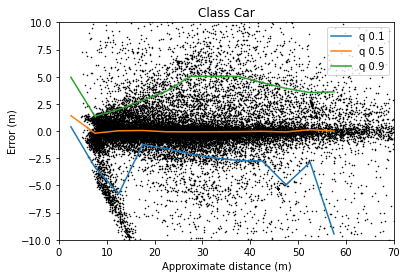

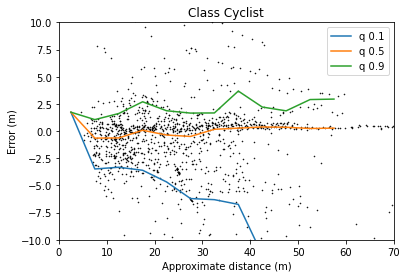

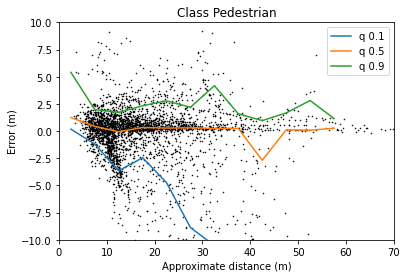

In [27]:
jump = 5
start = 0
end = 60

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train_class[(distance < df_train_class['distance_pointcloud']) & \
                                           (df_train_class['distance_pointcloud'] < distance+jump)].apply(lambda row: row['distance']-row['distance_pointcloud'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_1 = list(map(lambda x: x.get(0.1), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_9 = list(map(lambda x: x.get(0.9), MDistanceE_distances))

    Y = df_train_class['error_distance_pointcloud'].values
    X = df_train_class['distance_pointcloud'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,70))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

### Error base on pointcloud density

In [28]:
print(min(df_train['n_points']))
print(max(df_train['n_points']))

1
5761


array([[<AxesSubplot:title={'center':'n_points'}>]], dtype=object)

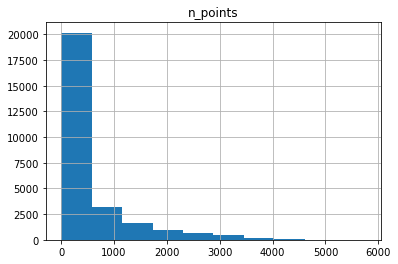

In [29]:
df_train.hist(column='n_points')

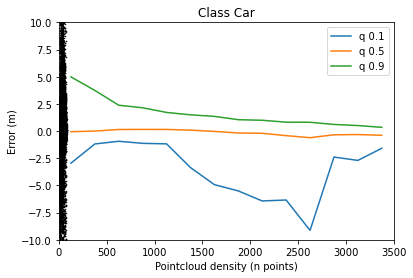

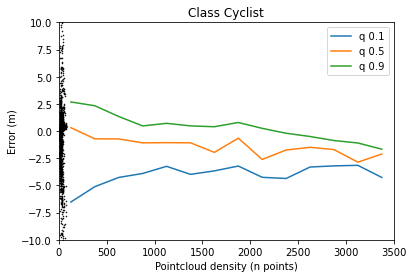

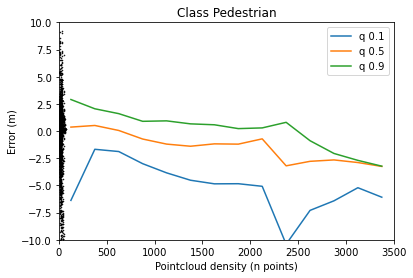

In [30]:
jump = 250
start = 0
end = 3500

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MPointE_points = []
    for point in range(start, end, jump):
        MPointE_point = df_train_class[(point < df_train_class['n_points']) & \
                                           (df_train_class['n_points'] < point+jump)].apply(lambda row: row['distance']-row['distance_pointcloud'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MPointE_points.append(MPointE_point)
    q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
    q_0_5 = list(map(lambda x: x.get(0.5), MPointE_points))
    q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

    Y = df_train_class['error_distance_pointcloud'].values
    X = df_train_class['distance_pointcloud'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Pointcloud density (n points)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,3500))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

# Create ensemble method

## Create error functions

Due to the possible appearance of a value not found in the training dataset, a function is created to infer the error range for any value.

In [31]:
class Regression_model_error:
    def __init__(self, height_distance, height_2d, pointcloud_distance, pointcloud_n_points):
        self.height_distance = height_distance
        self.height_2d = height_2d
        self.pointcloud_distance = pointcloud_distance
        self.pointcloud_n_points = pointcloud_n_points
    def __str__(self):
        return "height_distance: {%s},\nheight_2d: {%s},\npointcloud_distance: {%s},\npointcloud_n_points: {%s}"%\
                                (self.height_distance, self.height_2d, self.pointcloud_distance, self.pointcloud_n_points)

height_distance
Car
<function objective_8f at 0x7f752052aa60>
[ 6.62828093e-12 -1.04481465e-12 -2.23333757e-07  2.83676029e-05
 -1.55720497e-03  4.34684802e-02 -5.98359703e-01  3.46064730e+00
 -1.14886780e+00]
[1.0803813349452986, 0.4220332782240509, 0.3769344970383811, 0.30724680511227076, 0.234580143826022, 0.074885845162016, 0.07449490373921867]


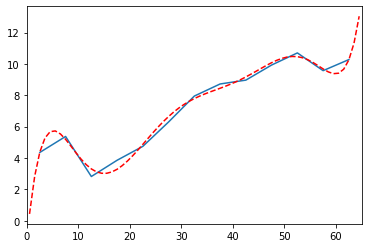

height_distance
Cyclist
<function objective_8f at 0x7f752052aa60>
[-4.21074119e-11  1.01987471e-08 -1.02123796e-06  5.52621058e-05
 -1.77995910e-03  3.53311218e-02 -4.19169480e-01  2.60283384e+00
 -2.70691731e+00]
[0.5596652496159467, 0.5592895005497154, 0.5141453373448271, 0.4446470481159797, 0.3298675945884391, 0.29962974518168306, 0.28389546884619665]


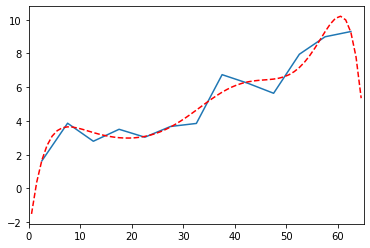

height_distance
Pedestrian
<function objective_8f at 0x7f752052aa60>
[ 3.79892872e-11 -9.11600898e-09  8.72304768e-07 -4.22048310e-05
  1.08486301e-03 -1.47179639e-02  1.15076833e-01 -5.86151601e-01
  4.03037710e+00]
[0.7903405882812683, 0.770949065881076, 0.149566005510459, 0.13811202519218221, 0.09982459843064567, 0.06860581105222786, 0.05579919391544974]


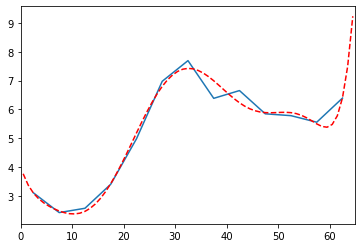

height_2d
Car
<function objective_8f at 0x7f752052aa60>
[-1.29801518e-16  8.96294667e-14 -1.59841684e-11 -1.68068020e-09
  8.11951991e-07 -8.28084225e-05  3.37475753e-03 -1.68362255e-01
  1.24641869e+01]
[2.165804457673078, 0.7886308630547233, 0.7771486066731335, 0.6478778124761131, 0.4764017254404829, 0.3303190121800323, 0.3276969715458913]


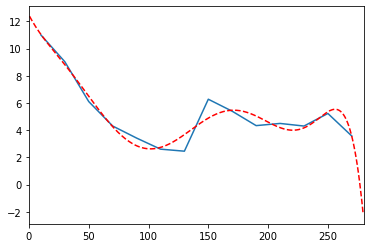

height_2d
Cyclist
<function objective_8f at 0x7f752052aa60>
[-1.02706703e-15  1.14727535e-12 -5.25947324e-10  1.27325727e-07
 -1.74198921e-05  1.33063374e-03 -5.13580656e-02  6.89030442e-01
  7.60834566e+00]
[1.8186069384756867, 0.4769338070859848, 0.4367397094790178, 0.35185176943229174, 0.3438335703667713, 0.3433995731430442, 0.17911943289126922]


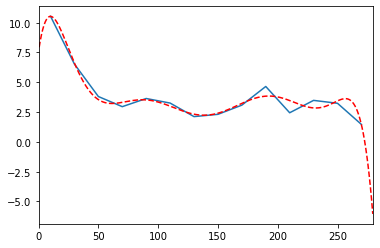

height_2d
Pedestrian
<function objective_8f at 0x7f752052aa60>
[ 2.78848227e-17 -2.51153314e-14  6.73197514e-12  4.74925562e-10
 -6.13911647e-07  1.31274234e-04 -1.21394501e-02  4.22113337e-01
  2.88038468e+00]
[0.4666029364748045, 0.4576740153396894, 0.27686010060829913, 0.06873075155359527, 0.03381321038935364, 0.03205535907000255, 0.03193445848684812]


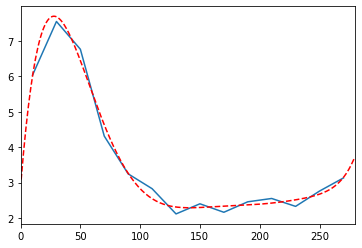

pointcloud_distance
Car
<function objective_8f at 0x7f752052aa60>
[ 6.86534421e-10 -1.64474942e-07  1.62699414e-05 -8.57334584e-04
  2.58733577e-02 -4.46711086e-01  4.15104137e+00 -1.78109947e+01
  2.91692024e+01]
[2.3165727366265716, 2.061595865606947, 1.8157655580223577, 1.1162131637547021, 1.0156473019138101, 1.0143920598651683, 0.1513400234325288]


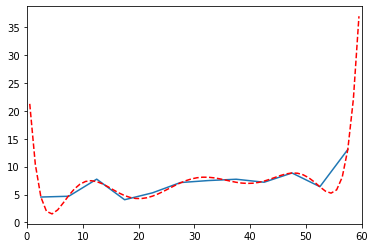

pointcloud_distance
Cyclist
<function objective_8f at 0x7f752052aa60>
[-1.86783688e-10  4.69914908e-08 -4.86402127e-06  2.68122585e-04
 -8.50724033e-03  1.56924917e-01 -1.61837762e+00  8.56020429e+00
 -1.34362962e+01]
[8.689314367227992, 1.4799731276874672, 1.0446114879935238, 0.27926340363383345, 0.21887072387858533, 0.150579574173024, 0.0867008185037814]


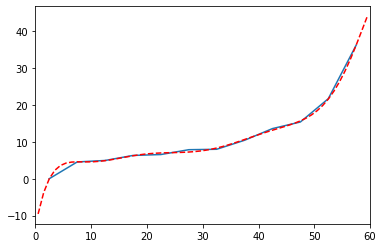

pointcloud_distance
Pedestrian
<function objective_8f at 0x7f752052aa60>
[ 7.83137378e-11 -2.82094903e-08  3.70515211e-06 -2.40376813e-04
  8.48121050e-03 -1.65616114e-01  1.73154805e+00 -8.52839860e+00
  1.79820560e+01]
[7.28892477843512, 5.721563029548125, 3.52227577804838, 3.364928623725831, 1.6833611843202325, 0.3901585075695544, 0.3789302852493524]


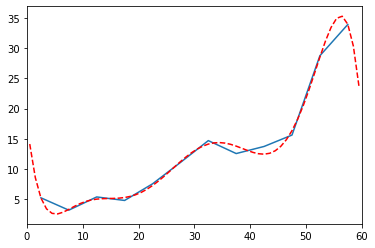

pointcloud_n_points
Car
<function objective_8f at 0x7f752052aa60>
[-4.79849533e-25  7.28650197e-21 -4.49893099e-17  1.45865743e-13
 -2.67009282e-10  2.72172192e-07 -1.34922954e-04  1.81080065e-02
  7.27149704e+00]
[4.802973173171112, 1.5757202814257536, 1.2700945227929148, 1.1326215519343164, 1.0553485208960913, 1.0207853616043792, 1.008050654264929]


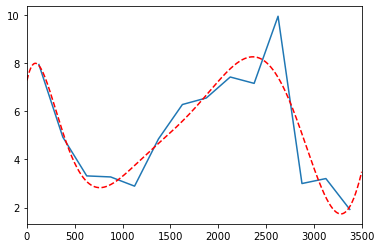

pointcloud_n_points
Cyclist
<function objective_8f at 0x7f752052aa60>
[-4.75921481e-25  6.70236674e-21 -3.89566976e-17  1.21146186e-13
 -2.17985489e-10  2.26670959e-07 -1.23619915e-04  2.29213721e-02
  7.86317765e+00]
[0.6104382847516893, 0.2953511440353189, 0.12015164016825194, 0.04897755740866226, 0.046314798442900325, 0.04614828374730221, 0.03361713523123011]


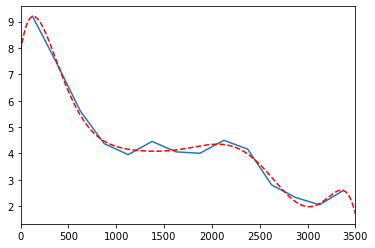

pointcloud_n_points
Pedestrian
<function objective_8f at 0x7f752052aa60>
[-1.81701899e-24  2.55758126e-20 -1.45831775e-16  4.31256032e-13
 -7.01763673e-10  6.09230218e-07 -2.41018915e-04  1.98815482e-02
  9.46485182e+00]
[5.047796991097156, 2.5330492483548808, 2.142670944305498, 2.134689859901623, 1.1702621793678696, 1.168241110738797, 0.9856069773180136]


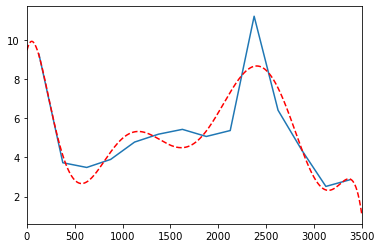

In [32]:
# Fuctions to fit
def objective_2f(x, a, b, c):
    return a * x**2 + b * x + c

def objective_3f(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def objective_4f(x, a, b, c, d, e):
    return a * x**4 + b * x**3 + c * x**2 + d * x + e

def objective_5f(x, a, b, c, d, e, f):
    return a * x**5 + b * x**4 + c * x**3 + d * x**2 + e * x + f

def objective_6f(x, a, b, c, d, e, f, g):
    return a * x**6 + b * x**5 + c * x**4 + d * x**3 + e * x**2 + f * x + g

def objective_7f(x, a, b, c, d, e, f, g, h):
    return a * x**7 + b * x**6 + c * x**5 + d * x**4 + e * x**3 + f * x**2 + g * x + h

def objective_8f(x, a, b, c, d, e, f, g, h, i):
    return a * x**8 + b * x**7 + c * x**6 + d * x**5 + e * x**4 + f * x**3 + g * x**2 + h * x + i

def objective_9f(x, a, b, c, d, e, f, g, h, i, j):
    return a * x**9 + b * x**8 + c * x**7 + d * x**6 + e * x**5 + f * x**4 + g * x**3 + h * x**2 + i * x + j

def objective_10f(x, a, b, c, d, e, f, g, h, i, j, k):
    return a * x**10 + b * x**9 + c * x**8 + d * x**7 + e * x**6 + f * x**5 + g * x**4 + h * x**3 + i * x**2 + j * x + k
 
# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [0, 0, 0, 0]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points.append(MPointE_point)
        q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
        q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_9, q_0_1)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y, list(map(lambda x: function(x, *popt), X))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.show()

Reduce the overfitting

height_distance
Car
<function objective_6f at 0x7f752052a950>
[-1.59431958e-08  3.33478419e-06 -2.65003701e-04  9.75563508e-03
 -1.59126521e-01  9.69609309e-01  2.96461651e+00]
[1.0107831768920004, 0.4060665575996938, 0.3650255055820828, 0.25836710480503633, 0.18483330110818477, 0.21677453713218675, 0.21579102872076059, 0.8244558198080805, 1.234267898970692]


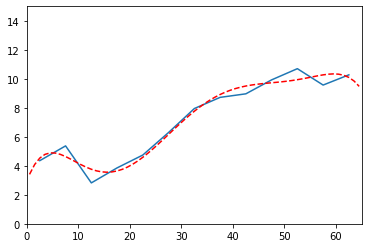

height_distance
Cyclist
<function objective_6f at 0x7f752052a950>
[-2.00376464e-08  4.13289471e-06 -3.29768115e-04  1.27233997e-02
 -2.38976949e-01  1.97305661e+00 -1.99989155e+00]
[0.28783484678521537, 0.29016800916967983, 0.3455296490991841, 0.23389252192283425, 0.2083746703520762, 0.2578042691188576, 0.22912965231793278, 0.7047755271271351, 0.9418207543820589]


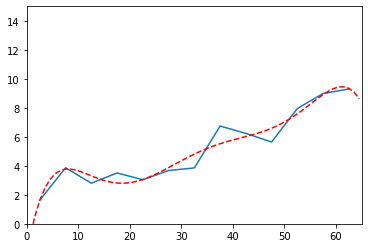

height_distance
Pedestrian
<function objective_10f at 0x7f752052ab70>
[-4.07009946e-14  9.70725797e-12 -7.83267633e-10  9.69580541e-09
  2.36736650e-06 -1.69124375e-04  5.29634098e-03 -8.79782312e-02
  7.85267179e-01 -3.44059477e+00  7.98077404e+00]
[0.6954121864074598, 0.6862475622529739, 0.3230776599197253, 0.3080025877895187, 0.2792658302358876, 0.3008340986263403, 0.31145860809203385, 0.20785761995924723, 0.18375997015510534]


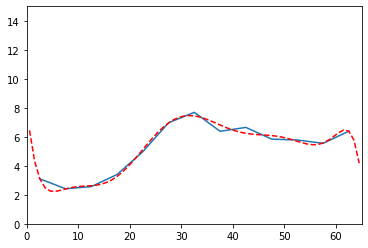

height_2d
Car
<function objective_9f at 0x7f752052aae8>
[ 1.46377930e-17 -1.85732232e-14  9.88570248e-12 -2.86834498e-09
  4.94102528e-07 -5.16854744e-05  3.22877669e-03 -1.12739942e-01
  1.77870292e+00  1.73168510e+00]
[1.8125008867083683, 0.7059342981362403, 0.7245716425743374, 0.6417682602960433, 0.6079297198091592, 0.5747576942771075, 0.5892666736654613, 0.4360747577954507, 0.7355720479586177]


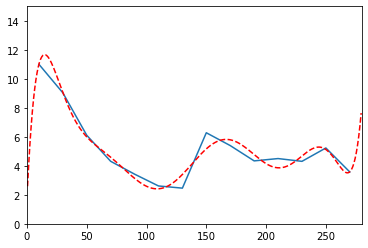

height_2d
Cyclist
<function objective_10f at 0x7f752052ab70>
[ 3.04072538e-19 -4.24172694e-16  2.53307948e-13 -8.45922804e-11
  1.73191580e-08 -2.24306096e-06  1.83231116e-04 -9.15327339e-03
  2.63329352e-01 -3.99701695e+00  3.17109453e+01]
[1.8619465771755386, 0.6667143067117217, 0.6634155518407883, 0.7931580334422574, 0.7370030092340177, 0.7495409307671997, 0.9004480978375506, 0.8826593047869437, 0.39161822713532957]


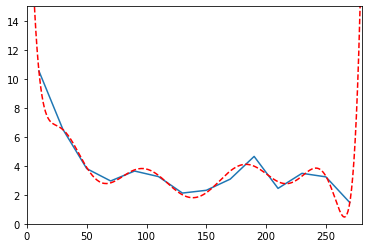

height_2d
Pedestrian
<function objective_10f at 0x7f752052ab70>
[ 5.18231556e-20 -7.84958798e-17  5.11912450e-14 -1.87896519e-11
  4.25700851e-09 -6.13640913e-07  5.58333264e-05 -3.05906575e-03
  9.07062833e-02 -1.20176648e+00  1.15370303e+01]
[0.5117937253562318, 0.537599535273803, 0.39689936867219733, 0.2901511649896187, 0.29799885513536795, 0.2991745495483577, 0.2901759455964077, 0.23517687810181115, 0.1159883331640712]


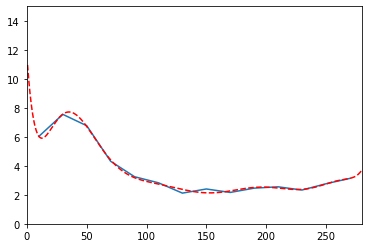

pointcloud_distance
Car
<function objective_5f at 0x7f752052a510>
[ 1.10250396e-06 -1.56418793e-04  7.92883260e-03 -1.71508066e-01
  1.52990198e+00  1.35807495e+00]
[0.6063284960939539, 0.9524267545825144, 0.7175777409312278, 0.5252972224598529, 0.8880941947754611, 0.8825620950100511, 3.9981762791824935, 4.32389322586827, 16.872940409937737]


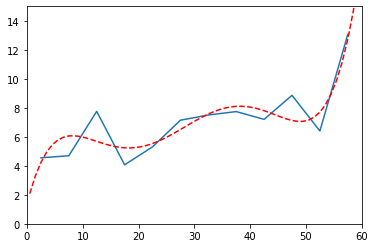

pointcloud_distance
Cyclist
<function objective_6f at 0x7f752052a950>
[ 2.48500756e-08 -3.31982896e-06  1.46108571e-04 -1.47935416e-03
 -4.97538275e-02  1.32457018e+00 -2.86909697e+00]
[3.8624828761965677, 1.3952791132976954, 1.0526383836739837, 0.3308036209313586, 0.2579400692429725, 0.25846980217174775, 0.5341296883934064, 0.7195002557946498, 3.215006331043432]


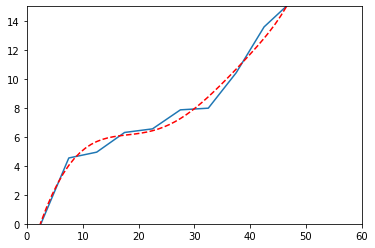

pointcloud_distance
Pedestrian
<function objective_8f at 0x7f752052aa60>
[ 7.83137378e-11 -2.82094903e-08  3.70515211e-06 -2.40376813e-04
  8.48121050e-03 -1.65616114e-01  1.73154805e+00 -8.52839860e+00
  1.79820560e+01]
[8.290376457239226, 5.741399280155718, 3.049638524492276, 3.098708438685601, 3.2355094729331313, 2.8705171304714323, 2.6847448924589177, 3.9506551415167235, 6.608874890746768]


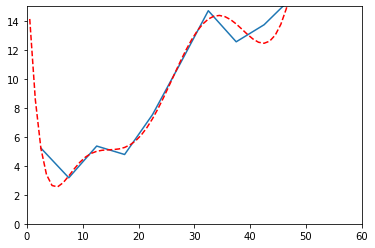

pointcloud_n_points
Car
<function objective_7f at 0x7f752052a048>
[ 5.68754327e-22 -6.32125021e-18  2.78707568e-14 -6.18908783e-11
  6.93419512e-08 -2.76785169e-05 -7.90926719e-03  9.22697934e+00]
[5.093154564171183, 1.4521159898138278, 1.5967937645870705, 1.607806823021935, 1.3834524810171644, 1.1822431248202059, 1.2410137804186792, 1.5788805745861987, 4.683035600017454]


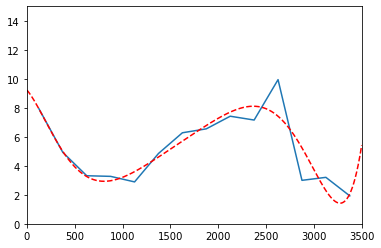

pointcloud_n_points
Cyclist
<function objective_10f at 0x7f752052ab70>
[ 1.49417604e-30 -2.63973705e-26  2.00206112e-22 -8.52061957e-19
  2.23248876e-15 -3.71723846e-12  3.91877679e-09 -2.52595639e-06
  9.27846438e-04 -1.75840849e-01  2.07675170e+01]
[0.9228651780758935, 0.5379065281466929, 0.45183465150467733, 0.41326556063533587, 0.4134475162141822, 0.41097986452400437, 0.4501563235589624, 0.5193703956121978, 0.4080258162218469]


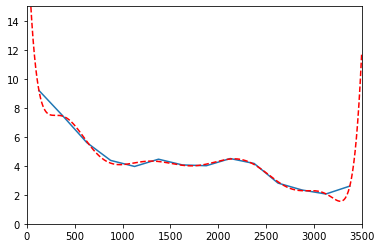

pointcloud_n_points
Pedestrian
<function objective_9f at 0x7f752052aae8>
[-3.15223010e-27  4.78305870e-23 -3.04052223e-19  1.05392416e-15
 -2.17548463e-12  2.74858620e-09 -2.11147829e-06  9.51475497e-04
 -2.30080744e-01  2.66882715e+01]
[8.575609597439934, 6.007070148706, 6.539923291196009, 6.554822306633787, 4.872241622096003, 4.870684977508157, 4.727774732020688, 3.7082180332872077, 3.960200131217178]


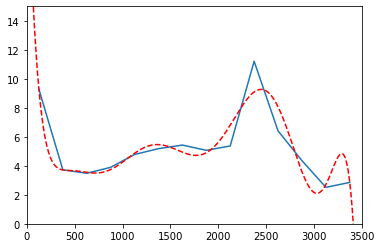

In [33]:
# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [0, 0, 0, 0]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points.append(MPointE_point)
        q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
        q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_9, q_0_1)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start + jump/2)
        end_ = int(end - jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points_.append(MPointE_point)
        q_0_1_ = list(map(lambda x: x.get(0.1), MPointE_points_))
        q_0_9_ = list(map(lambda x: x.get(0.9), MPointE_points_))
        Y_val = [x1 - x2 for (x1, x2) in zip(q_0_9_, q_0_1_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,15))
        plt.show()

Reduce overfitting in the first and last values

height_distance
Car
<function objective_7f at 0x7f752052a048>
[ 5.98392787e-10 -1.56696981e-07  1.66293941e-05 -9.09624652e-04
  2.67741201e-02 -3.98084747e-01  2.56542996e+00 -5.84653968e-01]
[1.0593778043378481, 0.598633339273621, 0.7546769245117477, 0.6988292143672171, 0.37168686887274, 0.22069182487518488, 0.921537867223368, 1.6450819899109874, 72.70065721088879]


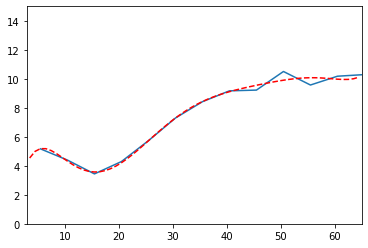

height_distance
Cyclist
<function objective_2f at 0x7f75204600d0>
[ 2.10860217e-03 -3.02038013e-02  3.30876800e+00]
[0.6501311781926473, 0.8039092758173474, 1.2095854116849996, 1.5738262809765664, 0.9493247630001489, 2.231173944937113, 20.266512040005324, 11.790600715331463, 10.36316923028575]


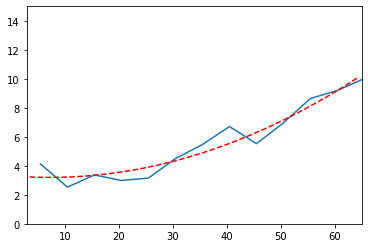

height_distance
Pedestrian
<function objective_6f at 0x7f752052a950>
[-9.52494488e-09  1.86194654e-06 -1.29953164e-04  3.73031511e-03
 -3.45949445e-02  4.21000624e-02  2.84518231e+00]
[0.842383559675836, 1.0032784401258221, 0.8261757216411875, 0.5643387675051176, 0.25237197561390473, 0.2752822411010818, 3.265005704404023, 55.93431448899925, 41.093627388737104]


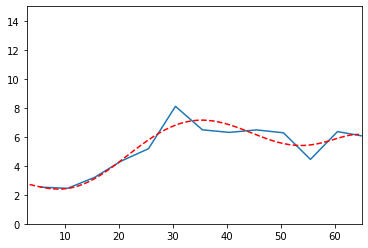

height_2d
Car
<function objective_6f at 0x7f752052a950>
[-3.09293713e-12  2.84986571e-09 -1.01532872e-06  1.72016829e-04
 -1.33523665e-02  3.28335499e-01  7.52713434e+00]
[3.4838858925649743, 0.8729932641993282, 0.8717801620802018, 0.8510337357513739, 0.7184855715080943, 0.9082818540411386, 1.3551669114559526, 35.3838237831584, 34.629347844500224]


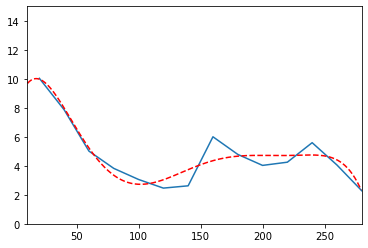

height_2d
Cyclist
<function objective_4f at 0x7f75204607b8>
[ 8.47000009e-09 -7.78577918e-06  2.30025516e-03 -2.63072353e-01
  1.28695128e+01]
[2.1600396143894454, 0.7306488126642114, 0.539929852462812, 0.6172484702848154, 0.8786058667903537, 0.954007723784414, 2.970628344571557, 26.588428479881923, 86.22354187054201]


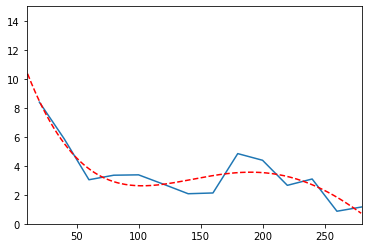

height_2d
Pedestrian
<function objective_5f at 0x7f752052a510>
[ 2.43171768e-10 -1.91830831e-07  5.49614509e-05 -6.71570657e-03
  2.90152706e-01  2.75605106e+00]
[0.4655935537828703, 0.4867870964387706, 0.3245986793157609, 0.3168474808630169, 0.4437117335743015, 2.752370232197973, 4.135345244283633, 13.272320422805773, 15.860246514356342]


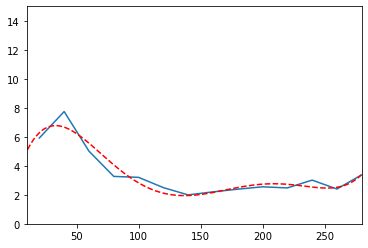

pointcloud_distance
Car
<function objective_4f at 0x7f75204607b8>
[ 5.59757304e-06 -6.04401511e-04  2.05864225e-02 -1.25258862e-01
  3.94740573e+00]
[2.7813660406644516, 2.4850280212793114, 2.038611672784189, 2.601370842645303, 8.701810865661605, 12.596213758232645, 81.86801216442974, 65.86210907197042, 341.3984672933906]


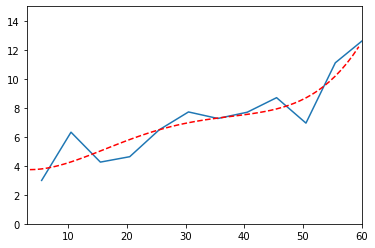

pointcloud_distance
Cyclist
<function objective_5f at 0x7f752052a510>
[-2.57532673e-06  3.80320225e-04 -2.02019906e-02  4.72274618e-01
 -4.48698624e+00  1.73994259e+01]
[52.621652702527065, 48.91246635156377, 32.820138482826366, 32.204099208082255, 35.42289780811552, 67.62888478468129, 85.09760768203338, 176.03676715475643, 2512.059214116667]


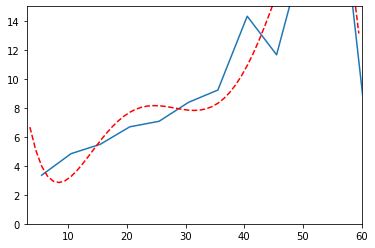

pointcloud_distance
Pedestrian
<function objective_2f at 0x7f75204600d0>
[ 0.01376202 -0.35072372  6.99090183]
[7.223883745609862, 13.647598667644035, 17.450588193198463, 16.73463008653846, 13.514174501596782, 26.38620008038594, 30.126712763019107, 246.47939429665487, 2414.7968848250107]


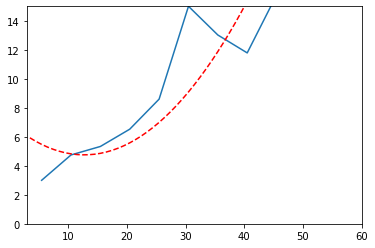

100%|██████████| 7481/7481 [02:43<00:00, 42.55it/s]

pointcloud_n_points
Car
<function objective_5f at 0x7f752052a510>
[ 8.51757730e-16 -7.06343953e-12  1.82275475e-08 -1.34244465e-05
 -2.91431146e-03  7.23252862e+00]
[5.082465089768675, 2.8352215722022778, 1.6306262925193442, 1.3587855785989167, 2.9717331345458846, 5.309972400085761, 4.451978284280664, 85.94348630901088, 124.12054530847129]


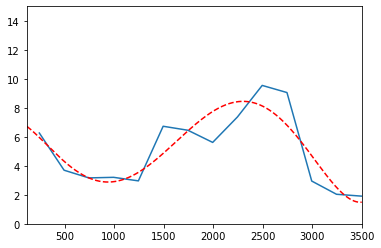

pointcloud_n_points
Cyclist
<function objective_3f at 0x7f7520460048>
[-5.30673595e-10  3.49860947e-06 -8.03147985e-03  9.85487061e+00]
[1.0268076656672913, 0.42460156193579335, 1.1576708699656892, 1.4236093925959967, 1.882347073690501, 2.017224287668431, 9.080548281990087, 37.09932650243648, 60.721133850211814]


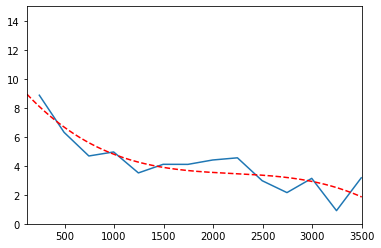

pointcloud_n_points
Pedestrian
<function objective_3f at 0x7f7520460048>
[-1.68578231e-09  8.01205031e-06 -8.93509826e-03  6.43583260e+00]
[6.954258722636177, 3.4121790818497977, 3.6289390523146006, 5.334660927707122, 5.4416632833566325, 3.4724762179703768, 27.690760165986603, 128.64331456106763, 106.50491158669328]


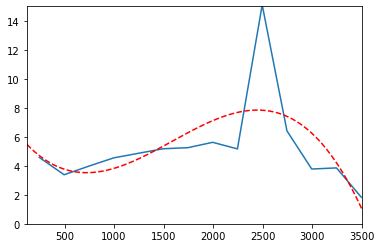

In [34]:
dict_models = {'height_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'height_2d':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_n_points':{'Car':None,'Cyclist':None,'Pedestrian':None}}

# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [3, 10, 3, 120]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points.append(MPointE_point)
        q_0_1 = list(map(lambda x: x.get(0.1), MPointE_points))
        q_0_9 = list(map(lambda x: x.get(0.9), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_9, q_0_1)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start - jump/2)
        end_ = int(end + jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.1,0.9])
            MPointE_points_.append(MPointE_point)
        q_0_1_ = list(map(lambda x: x.get(0.1), MPointE_points_))
        q_0_9_ = list(map(lambda x: x.get(0.9), MPointE_points_))
        Y_val = [x1 - x2 for (x1, x2) in zip(q_0_9_, q_0_1_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        dict_models[error_model_name][class_name] = Regression_model(function, popt)
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,15))
        plt.show()

In [35]:
dict_models

{'height_distance': {'Car': <__main__.Regression_model at 0x7f74f47ac978>,
  'Cyclist': <__main__.Regression_model at 0x7f74fc234550>,
  'Pedestrian': <__main__.Regression_model at 0x7f74fc30ad68>},
 'height_2d': {'Car': <__main__.Regression_model at 0x7f75526607b8>,
  'Cyclist': <__main__.Regression_model at 0x7f75204c69e8>,
  'Pedestrian': <__main__.Regression_model at 0x7f74fc74c128>},
 'pointcloud_distance': {'Car': <__main__.Regression_model at 0x7f74f47ee278>,
  'Cyclist': <__main__.Regression_model at 0x7f752052b048>,
  'Pedestrian': <__main__.Regression_model at 0x7f74fe191748>},
 'pointcloud_n_points': {'Car': <__main__.Regression_model at 0x7f74fc78cba8>,
  'Cyclist': <__main__.Regression_model at 0x7f74fe18f4a8>,
  'Pedestrian': <__main__.Regression_model at 0x7f74fe1c3cc0>}}

In [36]:
def get_error_model(dict_models):
    error_model = Regression_model_error(Regression_model_class(dict_models['height_distance']['Car'],
                                                             dict_models['height_distance']['Cyclist'],
                                                             dict_models['height_distance']['Pedestrian']),
                                      Regression_model_class(dict_models['height_2d']['Car'],
                                                             dict_models['height_2d']['Cyclist'],
                                                             dict_models['height_2d']['Pedestrian']),
                                      Regression_model_class(dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car']),
                                      Regression_model_class(dict_models['pointcloud_n_points']['Car'],
                                                             dict_models['pointcloud_n_points']['Cyclist'],
                                                             dict_models['pointcloud_n_points']['Pedestrian']))
    return error_model

In [37]:
error_model = get_error_model(dict_models)

In [38]:
print(error_model)

height_distance: {car: {function = <function objective_7f at 0x7f752052a048>, variables = [ 5.98392787e-10 -1.56696981e-07  1.66293941e-05 -9.09624652e-04
  2.67741201e-02 -3.98084747e-01  2.56542996e+00 -5.84653968e-01]},
pedestrian: {function = <function objective_2f at 0x7f75204600d0>, variables = [ 2.10860217e-03 -3.02038013e-02  3.30876800e+00]},
cyclist: {function = <function objective_6f at 0x7f752052a950>, variables = [-9.52494488e-09  1.86194654e-06 -1.29953164e-04  3.73031511e-03
 -3.45949445e-02  4.21000624e-02  2.84518231e+00]}},
height_2d: {car: {function = <function objective_6f at 0x7f752052a950>, variables = [-3.09293713e-12  2.84986571e-09 -1.01532872e-06  1.72016829e-04
 -1.33523665e-02  3.28335499e-01  7.52713434e+00]},
pedestrian: {function = <function objective_4f at 0x7f75204607b8>, variables = [ 8.47000009e-09 -7.78577918e-06  2.30025516e-03 -2.63072353e-01
  1.28695128e+01]},
cyclist: {function = <function objective_5f at 0x7f752052a510>, variables = [ 2.4317176

In [39]:
#with open('error_model.pkl', 'wb') as f:
    #f.write(pickle.dumps(error_model))

# Validate ensemble method

## Usage of the new method

In [40]:
def ajust_distance(error_model, height_distance, height_2d, pointcloud_distance, pointcloud_n_points, class_name):
    # Obtain regression models based on the object type
    if class_name == 'Car':
        height_distance_model = error_model.height_distance.car
        height_2d_model = error_model.height_2d.car
        pointcloud_distance_model = error_model.pointcloud_distance.car
        pointcloud_n_points_model = error_model.pointcloud_n_points.car
    elif class_name == 'Cyclist':
        height_distance_model = error_model.height_distance.cyclist
        height_2d_model = error_model.height_2d.cyclist
        pointcloud_distance_model = error_model.pointcloud_distance.cyclist
        pointcloud_n_points_model = error_model.pointcloud_n_points.cyclist
    elif class_name == 'Pedestrian':
        height_distance_model = error_model.height_distance.pedestrian
        height_2d_model = error_model.height_2d.pedestrian
        pointcloud_distance_model = error_model.pointcloud_distance.pedestrian
        pointcloud_n_points_model = error_model.pointcloud_n_points.pedestrian
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")   
    # Obtain an approximate error based on different metrics
    height_distance_error = height_distance_model.function(height_distance, *height_distance_model.variables)
    height_2d_error = height_2d_model.function(height_2d, *height_2d_model.variables)
    pointcloud_distance_error = pointcloud_distance_model.function(pointcloud_distance, *pointcloud_distance_model.variables)
    pointcloud_n_points_error = pointcloud_n_points_model.function(pointcloud_n_points, *pointcloud_n_points_model.variables)
    # Obtain final distance to use
    sum_error = height_distance_error + height_2d_error + pointcloud_distance_error + pointcloud_n_points_error
    distance = (1 - (height_distance_error + height_2d_error)/sum_error) * height_distance +\
               (1 - (pointcloud_distance_error + pointcloud_n_points_error)/sum_error) * pointcloud_distance
    return distance

In [41]:
ajust_distance(error_model, 30, 40, 20, 5, 'Car')

24.610772096881742

In [42]:
df_train['distance_ensemble'] = df_train.apply(lambda row: ajust_distance(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)
df_val['distance_ensemble'] = df_val.apply(lambda row: ajust_distance(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [43]:
df_train

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud,n_points,distance_ensemble
0,0,0,Pedestrian,0.00,0.0,-0.20,712.40,143.00,810.73,307.92,1.89,0.48,1.20,1.84,1.47,8.41,0.01,8.733533,164.92,98.33,0.21,False,False,8.597865,12.254393,0.135668,-3.520860,1463,10.200686
1,1,0,Car,0.00,0.0,1.85,387.63,181.54,423.81,203.12,1.67,1.87,3.69,-16.53,2.39,58.49,1.57,60.827897,21.58,36.18,-0.28,False,False,53.316196,58.681781,7.511702,2.146117,12,56.069839
2,1,1,Cyclist,0.00,3.0,-1.65,676.60,163.95,688.98,193.93,1.86,0.60,2.02,4.59,1.32,45.84,-1.55,46.088134,29.98,12.38,0.10,False,False,43.396508,45.473034,2.691626,0.615100,27,44.399545
3,2,0,Car,0.00,0.0,-1.67,657.39,190.13,700.07,223.39,1.41,1.58,4.36,3.18,2.27,34.38,-1.58,34.601296,33.26,42.68,0.09,False,False,36.825652,35.513878,-2.224356,-0.912582,111,36.097853
4,3,0,Car,0.00,0.0,1.55,614.24,181.78,727.31,284.77,1.57,1.73,4.15,1.00,1.75,13.22,1.62,13.372767,102.99,113.07,0.07,False,False,13.570701,13.763681,-0.197934,-0.390914,1016,13.658700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27309,5983,7,Car,0.00,2.0,-1.71,678.38,179.02,765.40,234.72,1.32,1.70,4.04,2.84,1.50,19.37,-1.57,19.634472,55.70,87.02,0.14,False,False,23.759745,21.711721,-4.125273,-2.077249,115,22.813607
27310,5983,8,Car,0.00,2.0,-1.72,668.22,167.79,726.04,215.88,1.56,1.48,3.36,2.95,1.42,25.30,-1.61,25.510956,48.09,57.82,0.11,False,False,26.950301,41.908662,-1.439345,-16.397705,98,34.041973
27311,5983,9,Car,0.00,1.0,-1.66,640.25,174.03,671.68,198.24,1.38,1.55,3.60,2.70,1.47,43.39,-1.60,43.498770,24.21,31.43,0.06,False,False,48.262606,43.478792,-4.763836,0.019978,40,45.544532
27312,5983,10,Car,0.77,3.0,2.27,0.00,196.98,95.57,298.45,1.35,1.59,3.41,-9.21,1.73,10.06,1.55,13.748476,101.47,95.57,-0.72,True,False,15.359191,8.980264,-1.610715,4.768212,406,12.725122


## Validate using KITTI difficulties

In [44]:
def define_difficulty(row):
    height = row['bottom'] - row['top']
    occlusion = row['occluded']
    truncation = row['truncated']
    if(height >= 40 and occlusion == 0 and truncation <= 0.15):
        return 0
    elif(height >= 25 and occlusion <= 1 and truncation <= 0.3):
        return 1
    elif(height >= 25 and occlusion <= 2 and truncation <= 0.5):
        return 2
    else:
        return 3

In [45]:
df_train['difficulty'] = df_train.apply(lambda row: define_difficulty(row), axis=1)
df_val['difficulty'] = df_val.apply(lambda row: define_difficulty(row), axis=1)

In [46]:
df_val

,frame,id,type,truncated,occluded,alpha,left,top,right,bottom,height,width,length,x,y,z,ry,distance,height_image,width_image,theta_ray,incomplete_2d_horizontal,incomplete_2d_bottom,distance_height,distance_pointcloud,error_distance_height,error_distance_pointcloud,n_points,distance_ensemble,difficulty
0,5984,0,Car,0.0,1.0,3.10,431.50,171.26,514.83,204.10,1.49,1.46,3.84,-6.60,1.44,34.58,2.91,35.233649,32.84,83.33,-0.19,False,False,37.223531,35.735784,-1.989883,-0.502135,228,36.377430,1
1,5984,1,Pedestrian,0.0,1.0,2.84,759.60,163.84,772.27,193.28,1.86,0.57,1.08,9.91,1.30,46.20,3.05,47.268786,29.44,12.67,0.21,False,False,43.724626,46.292605,3.544160,0.976181,27,44.811072,1
2,5984,2,Car,0.0,0.0,1.22,699.42,157.64,744.58,190.94,2.21,1.76,4.11,7.73,1.22,50.24,1.37,50.845835,33.30,45.16,0.15,False,False,36.788248,50.873979,14.057587,-0.028144,50,44.188144,1
3,5984,3,Car,0.0,1.0,-2.01,729.47,164.21,774.61,189.74,1.75,1.57,4.07,10.11,1.18,51.72,-1.82,52.712075,25.53,45.14,0.19,False,False,46.111278,52.218798,6.600798,0.493278,18,49.422269,1
4,5984,4,Car,0.0,0.0,-2.05,767.91,164.74,823.24,187.41,1.54,1.71,5.03,13.25,1.02,51.91,-1.80,53.584055,22.67,55.33,0.25,False,False,51.081492,53.655013,2.502564,-0.070957,29,52.478969,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6696,7480,9,Car,0.0,2.0,-0.33,749.78,170.88,917.51,243.48,1.77,1.69,3.82,5.72,1.75,18.85,-0.04,19.776334,72.60,167.73,0.29,False,False,18.821832,20.637356,0.954502,-0.861021,449,19.596178,2
6697,7480,10,Car,0.0,1.0,-2.90,344.07,180.05,479.10,224.15,1.49,1.59,4.44,-7.12,1.78,26.03,3.12,27.044846,44.10,135.03,-0.26,False,False,29.010171,26.912365,-1.965325,0.132481,380,27.857018,1
6698,7480,11,Car,0.0,2.0,-2.91,382.70,179.71,495.48,219.10,1.48,1.63,4.10,-6.79,1.78,28.78,-3.14,29.623654,39.39,112.78,-0.23,False,False,31.921166,31.300070,-2.297512,-1.676415,56,31.593126,2
6699,7480,12,Car,0.0,0.0,-1.69,631.71,179.85,678.40,214.37,1.41,1.56,4.08,1.90,1.74,31.98,-1.63,32.083610,34.52,46.69,0.06,False,False,35.686282,32.021300,-3.602672,0.062310,121,33.653582,1


In [47]:
def evaluate(distance_column):
    difficulties = [0, 1, 2]                       
    classes = ["Car","Cyclist","Pedestrian"]
    text_difficulties = ["Easy", "Moderate", "Hard"]

    def mse(frame):
        df_frame = df_val[df_val['frame'] == frame]
        bbs_distance_gt = df_frame['distance'].tolist()
        bbs_distance_approx = df_frame[distance_column].tolist()
        mse_value = mean_squared_error(bbs_distance_gt, bbs_distance_approx)

        return mse_value

    print("################################", end="\n\n")

    # Iterate over difficulties
    for difficulty, text_difficulty in zip(difficulties, text_difficulties):
        # Iterate over classes
        for class_name in classes:                  
            df_difficulty = df_val[(df_val['difficulty'] <= difficulty) & (df_val['type'] == class_name)]
            mse_by_frame = df_difficulty['frame'].unique()
            start_time = time.time()
            mse_by_frame = list(map(mse, mse_by_frame))

            mse_by_frame_without_none = list(filter(partial(is_not, None), mse_by_frame))

            mean_mse = statistics.mean(mse_by_frame_without_none)
            print("--- %s seconds to calculate MSE, %s difficulty, %s class  ---" % (time.time() - start_time, text_difficulty, class_name))

            print("\nMean of all MSE by frame, %s difficulty, %s class = %s\n" % (text_difficulty, class_name, mean_mse))

        print("################################", end="\n\n")

In [48]:
evaluate('distance_ensemble')

################################

--- 0.5103633403778076 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 10.24969753040769

--- 0.05869412422180176 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 4.633928963147564

--- 0.13988971710205078 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 4.206426941276516

################################

--- 0.7270028591156006 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 10.623386992534993

--- 0.08612656593322754 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 7.985143911802827

--- 0.1770031452178955 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean of a

# Use of the square error in the ensemble model 

In [49]:
def ajust_distance2(error_model, height_distance, height_2d, pointcloud_distance, pointcloud_n_points, class_name):
    # Obtain regression models based on the object type
    if class_name == 'Car':
        height_distance_model = error_model.height_distance.car
        height_2d_model = error_model.height_2d.car
        pointcloud_distance_model = error_model.pointcloud_distance.car
        pointcloud_n_points_model = error_model.pointcloud_n_points.car
    elif class_name == 'Cyclist':
        height_distance_model = error_model.height_distance.cyclist
        height_2d_model = error_model.height_2d.cyclist
        pointcloud_distance_model = error_model.pointcloud_distance.cyclist
        pointcloud_n_points_model = error_model.pointcloud_n_points.cyclist
    elif class_name == 'Pedestrian':
        height_distance_model = error_model.height_distance.pedestrian
        height_2d_model = error_model.height_2d.pedestrian
        pointcloud_distance_model = error_model.pointcloud_distance.pedestrian
        pointcloud_n_points_model = error_model.pointcloud_n_points.pedestrian
    else:
        raise ValueError("Type must be Car, Pedestrian or Cyclist")   
    # Obtain an approximate error based on different metrics
    height_distance_error = height_distance_model.function(height_distance, *height_distance_model.variables) ** 2
    height_2d_error = height_2d_model.function(height_2d, *height_2d_model.variables) ** 2
    pointcloud_distance_error = pointcloud_distance_model.function(pointcloud_distance, *pointcloud_distance_model.variables) ** 2
    pointcloud_n_points_error = pointcloud_n_points_model.function(pointcloud_n_points, *pointcloud_n_points_model.variables) ** 2
    # Obtain final distance to use
    sum_error = height_distance_error + height_2d_error + pointcloud_distance_error + pointcloud_n_points_error
    distance = (1 - (height_distance_error + height_2d_error)/sum_error) * height_distance +\
               (1 - (pointcloud_distance_error + pointcloud_n_points_error)/sum_error) * pointcloud_distance
    return distance

In [50]:
df_train['distance_ensemble2'] = df_train.apply(lambda row: ajust_distance2(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)
df_val['distance_ensemble2'] = df_val.apply(lambda row: ajust_distance2(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [51]:
evaluate('distance_ensemble2')

################################

--- 0.5116443634033203 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 10.929793504480335

--- 0.06074643135070801 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 4.177314298756267

--- 0.14641308784484863 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 4.1961699069484135

################################

--- 0.7649474143981934 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 11.497433839188256

--- 0.09195494651794434 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 8.108083256049817

--- 0.18776464462280273 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean o

# Using centiles instead of deciles to create the error function

height_distance
Car
<function objective_6f at 0x7f752052a950>
[-1.62474016e-08  3.59747637e-06 -3.07431611e-04  1.23736293e-02
 -2.26145819e-01  1.74878609e+00  4.24660243e+00]
[5.032636430189489, 0.9657273620766882, 1.258382570473459, 1.0367113779863042, 0.5845693609104752, 4.621739949251877, 13.520542960092229, 66.79417636507532, 27.696997243442013]


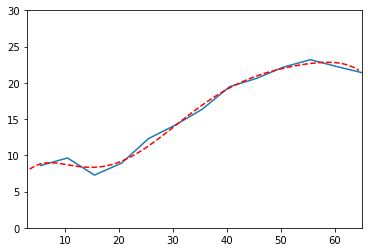

height_distance
Cyclist
<function objective_3f at 0x7f7520460048>
[ 4.99874253e-05 -8.36265687e-03  4.39954656e-01  2.50014906e+00]
[1.9316258570773868, 1.6015182568572623, 2.897595993291794, 4.371900718220206, 2.093350436596076, 5.000793431476389, 24.323415191193483, 27.21018503527651, 542.5368277405844]


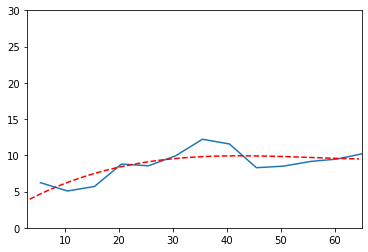

height_distance
Pedestrian
<function objective_3f at 0x7f7520460048>
[ 8.17585155e-05 -1.48830493e-02  7.10407554e-01 -7.07085438e-02]
[1.3145441052255886, 1.2883989011414094, 1.766363076535757, 2.2141058388976655, 1.6176819666464664, 1.8902762774818203, 3.3757305633952712, 19.59136715526332, 9.733391860642433]


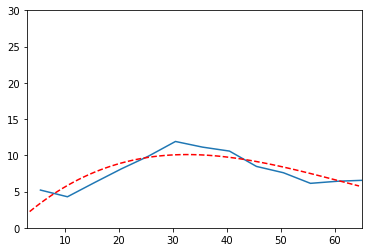

height_2d
Car
<function objective_6f at 0x7f752052a950>
[-4.47293901e-12  3.89698307e-09 -1.26335182e-06  1.79293477e-04
 -8.63056536e-03 -2.66031446e-01  3.20590521e+01]
[8.762212642583853, 3.0866615057095936, 5.048772830554471, 5.717336251823122, 2.8083013466559392, 4.053822125521533, 19.456090626875476, 17.99713507480943, 34.304426340782946]


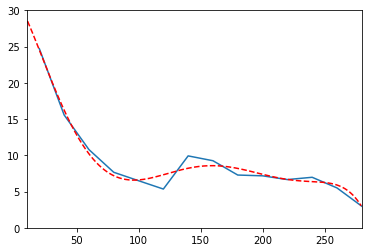

height_2d
Cyclist
<function objective_6f at 0x7f752052a950>
[ 2.78849909e-12 -1.98071367e-09  4.49275212e-07 -2.55864867e-05
 -2.49884249e-03  1.93519936e-01  8.36739434e+00]
[2.277144559062403, 1.8052474855349951, 1.7033051477331933, 1.4629924200250997, 1.30964856581576, 2.246390063290042, 5.061524328598671, 11.978322769715113, 37.48426948732761]


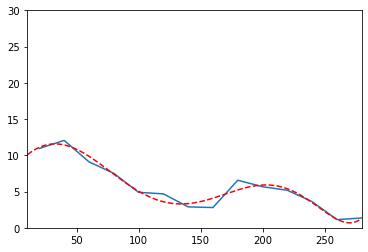

height_2d
Pedestrian
<function objective_7f at 0x7f752052a048>
[ 5.32633100e-15 -7.16687514e-12  4.08376405e-09 -1.25741005e-06
  2.19366101e-04 -2.05238367e-02  8.30141401e-01 -1.36575057e-03]
[2.79578855816727, 3.032801959263085, 1.391396822515903, 0.29484057913601247, 0.1316294812809707, 0.1084229279969826, 2.24398390589788, 2.329114755352743, 1.5167056009631632]


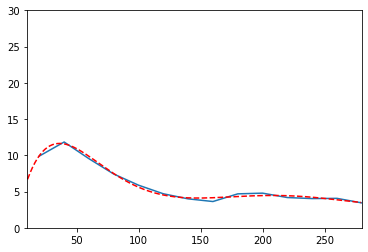

pointcloud_distance
Car
<function objective_4f at 0x7f75204607b8>
[-1.27953589e-06  2.04915836e-04 -6.34599762e-03  1.66529464e-01
  2.98399931e+01]
[54.22127424121129, 52.39846872890215, 51.36843178460098, 121.16206185715569, 117.39788066971866, 194.6289536584391, 862.2521959125562, 6830.318019394801, 21147.288174611575]


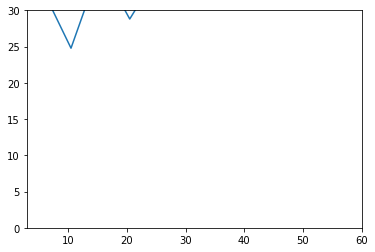

pointcloud_distance
Cyclist
<function objective_6f at 0x7f752052a950>
[-1.24255306e-07  2.32117797e-05 -1.68541892e-03  6.02118252e-02
 -1.09548193e+00  9.76769420e+00 -2.00989768e+01]
[93.4049541255509, 89.34091354466419, 63.26407723708125, 54.50598746200173, 23.61401415619446, 29.371883081165127, 424.8366518055987, 797.8288278464629, 21592.157427967086]


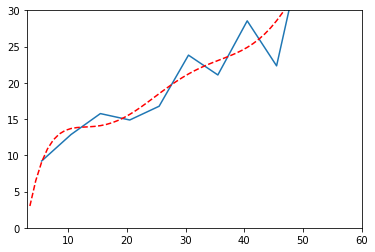

pointcloud_distance
Pedestrian
<function objective_6f at 0x7f752052a950>
[-1.81702565e-08  2.66794989e-06 -1.03212334e-04 -1.02197430e-03
  1.20400103e-01 -1.17568566e+00  1.51814187e+01]
[9.483992337166795, 11.496033271111932, 13.960927903491662, 10.821867879344447, 8.745179476638867, 57.36569024387499, 27.494863132958145, 1031.0766622392064, 63842.03723603244]


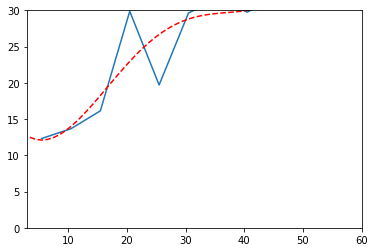

pointcloud_n_points
Car
<function objective_9f at 0x7f752052aae8>
[-4.01384456e-29  1.71236771e-24 -2.09799378e-20  1.24118198e-16
 -4.15369472e-13  8.33456149e-10 -1.01607839e-06  7.42303592e-04
 -3.09556667e-01  7.38607916e+01]
[48.86255145786438, 23.02806802189484, 12.132473751913558, 9.29777974290494, 7.44380250402678, 5.383074624544116, 2.0046861384990433, 1.8746045888212841, 300.8723079116478]


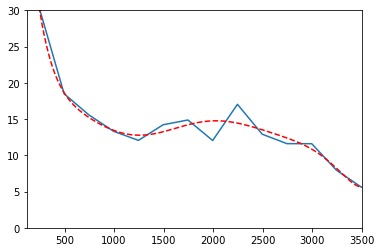

pointcloud_n_points
Cyclist
<function objective_6f at 0x7f752052a950>
[-6.91380964e-21 -8.89370954e-17  3.74539698e-12 -2.51178735e-08
  6.49012001e-05 -7.29792822e-02  3.84441494e+01]
[13.809006067962258, 7.283844120526182, 5.174607043353478, 4.856338617662501, 4.840347620380226, 6.304504822357871, 8.463782240263445, 131.0531368887659, 141.28362257524773]


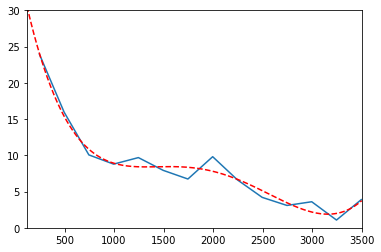

pointcloud_n_points
Pedestrian
<function objective_8f at 0x7f752052aa60>
[ 7.79407398e-25 -1.23734524e-20  8.16067776e-17 -2.87762691e-13
  5.82885014e-10 -6.84319930e-07  4.58422430e-04 -1.71791910e-01
  4.10967975e+01]
[69.17246657061142, 39.40214103170057, 26.38242046449857, 34.37155238425373, 34.5113100868068, 27.225959500461087, 21.628263004111698, 63.89838014227033, 583.8044783892002]


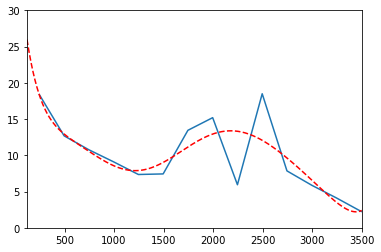

In [52]:
dict_models = {'height_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'height_2d':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_n_points':{'Car':None,'Cyclist':None,'Pedestrian':None}}

# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [3, 10, 3, 120]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points.append(MPointE_point)
        q_0_01 = list(map(lambda x: x.get(0.01), MPointE_points))
        q_0_99 = list(map(lambda x: x.get(0.99), MPointE_points))

        # Create axis
        Y = [x1 - x2 for (x1, x2) in zip(q_0_99, q_0_01)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start - jump/2)
        end_ = int(end + jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points_.append(MPointE_point)
        q_0_01_ = list(map(lambda x: x.get(0.01), MPointE_points_))
        q_0_99_ = list(map(lambda x: x.get(0.99), MPointE_points_))
        Y_val = [x1 - x2 for (x1, x2) in zip(q_0_99_, q_0_01_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        dict_models[error_model_name][class_name] = Regression_model(function, popt)
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,30))
        plt.show()

In [53]:
error_model = get_error_model(dict_models)

In [54]:
df_train['distance_ensemble3'] = df_train.apply(lambda row: ajust_distance(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']), axis=1)
df_val['distance_ensemble3'] = df_val.apply(lambda row: ajust_distance(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [55]:
evaluate('distance_ensemble3')

################################

--- 0.5016043186187744 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 8.100481353695555

--- 0.05836749076843262 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 3.8176545112424916

--- 0.13754034042358398 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 3.092843538368641

################################

--- 0.7250015735626221 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 8.52293066321527

--- 0.08623266220092773 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 5.693784943825007

--- 0.1776409149169922 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean of al

# Using centiles instead of deciles to create the error function and square error in the ensemble model

height_distance
Car
<function objective_6f at 0x7f752052a950>
[-1.41589730e-07  3.49901856e-05 -3.45208536e-03  1.59661689e-01
 -3.16129166e+00  2.55523303e+01  9.43922029e+00]
[6659.332717170122, 1668.8293861106956, 1076.4118680307554, 1034.6216034786428, 958.4656254444959, 2754.51444049659, 3545.531215406751, 36025.42178401233, 25863.85591197898]


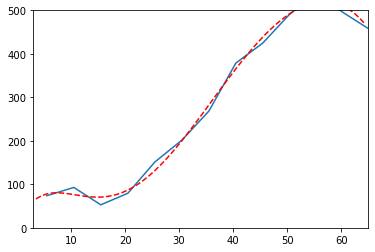

height_distance
Cyclist
<function objective_6f at 0x7f752052a950>
[-4.57058268e-07  9.42314423e-05 -7.24326131e-03  2.54304051e-01
 -4.03487791e+00  2.73073026e+01 -2.74912541e+01]
[606.6928039802899, 574.6384423751114, 617.6975880725613, 783.1586342372084, 222.01319045167136, 666.8603623763473, 6764.542395305936, 10185.283104918764, 198733.59329212477]


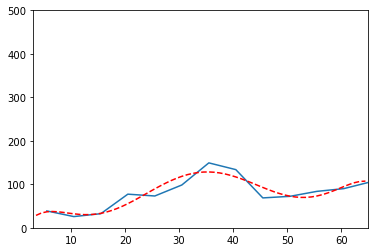

height_distance
Pedestrian
<function objective_7f at 0x7f752052a048>
[ 6.51250933e-09 -1.90747725e-06  2.18493725e-04 -1.22909015e-02
  3.48125557e-01 -4.59704723e+00  2.62522669e+01 -2.65033669e+01]
[488.3465918390032, 501.15779531765935, 491.49782356714223, 589.8225295028717, 291.29870761473154, 250.6495846911027, 513.3173985902567, 4287.937644245057, 2493.264078478366]


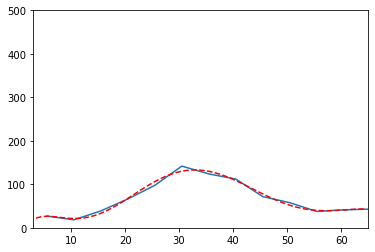

height_2d
Car
<function objective_3f at 0x7f7520460048>
[-1.81342029e-04  9.46005734e-02 -1.52141908e+01  7.89660415e+02]
[5642.115006899651, 2991.6452766343705, 4778.364052100179, 7291.899065289078, 7441.885362132, 9629.607558602587, 20222.018586183258, 20827.827895775754, 7902.854742229524]


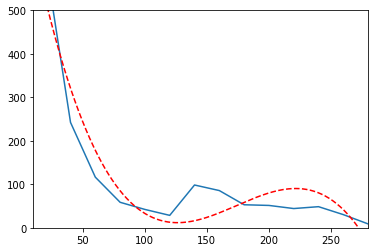

height_2d
Cyclist
<function objective_5f at 0x7f752052a510>
[ 7.01528666e-09 -5.50496495e-06  1.54911368e-03 -1.83659580e-01
  7.58747079e+00  3.45348567e+01]
[392.80291717725737, 285.9977519605975, 264.750786143407, 250.63915538585144, 297.68805029169886, 592.4581151387807, 2010.6606543654575, 3647.1195455682014, 2162.000032434438]


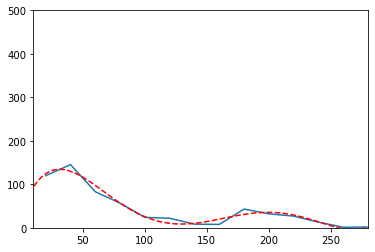

height_2d
Pedestrian
<function objective_6f at 0x7f752052a950>
[-5.13384533e-11  5.17170595e-08 -2.04826715e-05  3.99451294e-03
 -3.87631275e-01  1.58380094e+01 -9.02605890e+01]
[733.9314399476111, 806.3603575752927, 463.6103554569058, 124.68870915888971, 51.68342526244614, 125.34622643994201, 729.5996505086862, 998.1292667985833, 440.88799848585876]


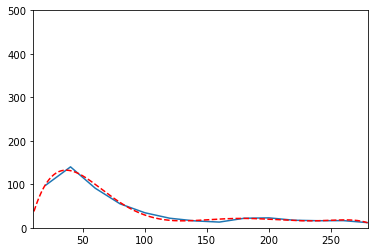

pointcloud_distance
Car
<function objective_4f at 0x7f75204607b8>
[-4.13962126e-04  5.91086137e-02 -2.43339959e+00  4.29373243e+01
  7.61769991e+02]
[132505.03319490404, 122615.86147101715, 111136.75738319752, 346101.38800678705, 296340.1509926887, 561557.4879015503, 2664235.983422763, 26747203.622789476, 80795852.71579212]


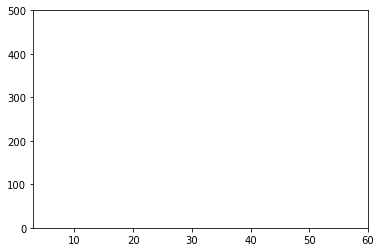

pointcloud_distance
Cyclist
<function objective_6f at 0x7f752052a950>
[-6.40502251e-06  1.15165038e-03 -7.99071374e-02  2.71018814e+00
 -4.63800577e+01  3.80629231e+02 -9.93271381e+02]
[208403.55613621682, 186745.56159390064, 126603.17704519125, 76624.42112920622, 33130.42630113533, 73424.51928192479, 1070833.622400592, 4193178.4415482315, 62863718.56318379]


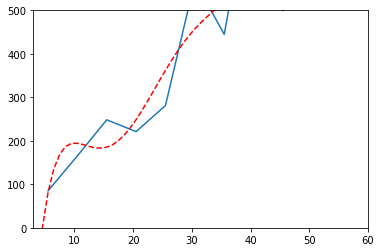

pointcloud_distance
Pedestrian
<function objective_6f at 0x7f752052a950>
[-2.83224504e-06  5.18697110e-04 -3.47595559e-02  1.04834577e+00
 -1.41347308e+01  1.00396446e+02 -1.32263475e+02]
[41508.021253838546, 54965.81738298212, 71648.91497414581, 58870.34265526812, 38847.82132208793, 161147.79758012618, 76198.31880466106, 1970507.49673346, 165541335.4712248]


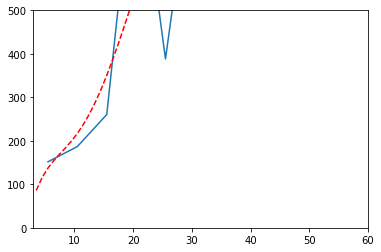

pointcloud_n_points
Car
<function objective_9f at 0x7f752052aae8>
[-1.16626348e-26  2.33841802e-22 -2.00836899e-18  9.64586390e-15
 -2.83743834e-11  5.26877476e-08 -6.15437829e-05  4.38109262e-02
 -1.75948967e+01  3.33787406e+03]
[212748.68381765188, 146855.69992335475, 101766.4620337595, 81711.34916485651, 66225.20586647947, 48783.01473675529, 32559.916079657192, 26771.992400578023, 163289.42107554898]


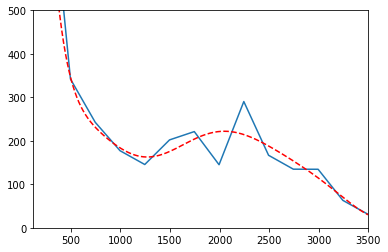

pointcloud_n_points
Cyclist
<function objective_7f at 0x7f752052a048>
[-4.26176720e-21  6.52928135e-17 -4.33799438e-13  1.63719422e-09
 -3.77547616e-06  5.20580226e-03 -3.88468673e+00  1.26571034e+03]
[20025.015057686636, 10152.6318349726, 3526.144158057745, 1309.0151400313343, 1052.972997744614, 886.6293415357026, 1005.8875992712135, 21359.22276774092, 24615.8873348174]


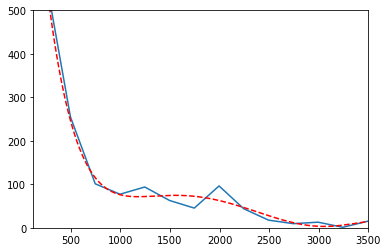

pointcloud_n_points
Pedestrian
<function objective_9f at 0x7f752052aae8>
[-1.23332536e-25  2.07218059e-21 -1.48025754e-17  5.86463129e-14
 -1.40913831e-10  2.10819086e-07 -1.93951901e-04  1.04440118e-01
 -2.96781293e+01  3.54614305e+03]
[157656.4277500755, 124426.93365597297, 101408.63865103527, 113290.56391662935, 108756.65143061808, 92379.96671304485, 94612.90241055904, 53203.21142596913, 336374.65700390184]


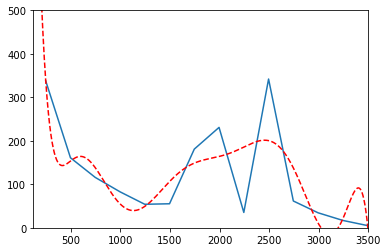

In [56]:
dict_models = {'height_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'height_2d':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_distance':{'Car':None,'Cyclist':None,'Pedestrian':None},
               'pointcloud_n_points':{'Car':None,'Cyclist':None,'Pedestrian':None}}

# Variables for the different error models
jumps = [5, 20, 5, 250]
starts = [3, 10, 3, 120]
ends = [65, 280, 60, 3500]

functions = [objective_2f, objective_3f, objective_4f, objective_5f, objective_6f, objective_7f, objective_8f, objective_9f, objective_10f]
error_model_names = ['height_distance', 'height_2d', 'pointcloud_distance', 'pointcloud_n_points']
model_columns = ['distance_height', 'height_image', 'distance_pointcloud', 'n_points']
class_names = ['Car', 'Cyclist', 'Pedestrian']

# Loop over error models
for error_model_name, model_column, jump, start, end in zip(error_model_names, model_columns,jumps, starts, ends):
    # Loop over class names
    for class_name in class_names:
        
        approximate_distance_column = 'distance_' + error_model_name.split("_")[0]
        
        df_train_class = df_train[df_train['type'] == class_name]
    
        # Calculate deciles
        MPointE_points = []
        for point in range(start, end, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points.append(MPointE_point)
        q_0_01 = list(map(lambda x: x.get(0.01), MPointE_points))
        q_0_99 = list(map(lambda x: x.get(0.99), MPointE_points))

        # Create axis
        Y = [(x1 - x2)**2 for (x1, x2) in zip(q_0_99, q_0_01)]
        X = (np.array(list(range(start,end,jump)))+jump/2).tolist()
        
        # Only one function with training data is to be created, so the validation dataset is not necessary
        start_ = int(start - jump/2)
        end_ = int(end + jump/2)
        MPointE_points_ = []
        for point in range(start_, end_, jump):
            MPointE_point = df_train_class[(point < df_train_class[model_column]) & \
                                               (df_train_class[model_column] < point+jump)].apply(lambda row: row['distance']-row[approximate_distance_column],
                                                                                                        axis=1).quantile(q=[0.01,0.99])
            MPointE_points_.append(MPointE_point)
        q_0_01_ = list(map(lambda x: x.get(0.01), MPointE_points_))
        q_0_99_ = list(map(lambda x: x.get(0.99), MPointE_points_))
        Y_val = [(x1 - x2)**2 for (x1, x2) in zip(q_0_99_, q_0_01_)]
        X_val = (np.array(list(range(start_,end_,jump)))+jump/2).tolist()
        
        
        popt_functions = list(map(lambda function: curve_fit(function, X, Y,maxfev = 1000000)[0], functions))
        mses_class_model_error = list(map(lambda function, popt: mean_squared_error(Y_val, list(map(lambda x: function(x, *popt), X_val))), functions, popt_functions))
        
        min_mse = min(mses_class_model_error)
        id_function = mses_class_model_error.index(min_mse)
        function = functions[id_function]
        popt = popt_functions[id_function]
        
        X_line = (np.array(list(range(start,end,1)))+1/2).tolist()
        
        dict_models[error_model_name][class_name] = Regression_model(function, popt)
        
        print(error_model_name)
        print(class_name)
        print(function)
        print(popt)
        print(mses_class_model_error)
        plt.plot(X, Y)
        plt.plot(X_line, list(map(lambda x: function(x, *popt), X_line)), '--', color='red')
        plt.xlim((start,end))
        plt.ylim((0,500))
        plt.show()

In [57]:
error_model = get_error_model(dict_models)

In [58]:
error_model = Regression_model_error(Regression_model_class(dict_models['height_distance']['Car'],
                                                             dict_models['height_distance']['Cyclist'],
                                                             dict_models['height_distance']['Pedestrian']),
                                      Regression_model_class(dict_models['height_2d']['Car'],
                                                             dict_models['height_2d']['Cyclist'],
                                                             dict_models['height_2d']['Pedestrian']),
                                      Regression_model_class(dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car']),
                                      Regression_model_class(dict_models['pointcloud_n_points']['Car'],
                                                             dict_models['pointcloud_n_points']['Cyclist'],
                                                             dict_models['pointcloud_n_points']['Pedestrian']))

In [59]:
df_train['distance_ensemble4'] = df_train.apply(lambda row: ajust_distance(error_model,
                                                                          row['distance_height'],
                                                                          row['height_image'],
                                                                          row['distance_pointcloud'],
                                                                          row['n_points'],
                                                                          row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)
df_val['distance_ensemble4'] = df_val.apply(lambda row: ajust_distance(error_model,
                                                                      row['distance_height'],
                                                                      row['height_image'],
                                                                      row['distance_pointcloud'],
                                                                      row['n_points'],
                                                                      row['type']) if row['distance_pointcloud'] != None else row['distance_height'], axis=1)

In [60]:
evaluate('distance_ensemble4')

################################

--- 0.5018541812896729 seconds to calculate MSE, Easy difficulty, Car class  ---

Mean of all MSE by frame, Easy difficulty, Car class = 7.923654781777372

--- 0.0568082332611084 seconds to calculate MSE, Easy difficulty, Cyclist class  ---

Mean of all MSE by frame, Easy difficulty, Cyclist class = 3.8881747614899727

--- 0.1334211826324463 seconds to calculate MSE, Easy difficulty, Pedestrian class  ---

Mean of all MSE by frame, Easy difficulty, Pedestrian class = 3.096532546222492

################################

--- 0.730090856552124 seconds to calculate MSE, Moderate difficulty, Car class  ---

Mean of all MSE by frame, Moderate difficulty, Car class = 8.282049220730803

--- 0.08699202537536621 seconds to calculate MSE, Moderate difficulty, Cyclist class  ---

Mean of all MSE by frame, Moderate difficulty, Cyclist class = 5.3112969966780925

--- 0.17786312103271484 seconds to calculate MSE, Moderate difficulty, Pedestrian class  ---

Mean of al

# Error of the ensemble model

In [61]:
df_train['error_distance_ensemble4'] = df_train['distance'] - df_train['distance_ensemble4']
df_val['error_distance_ensemble4'] = df_val['distance'] - df_val['distance_ensemble4']

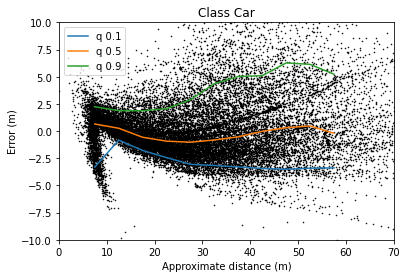

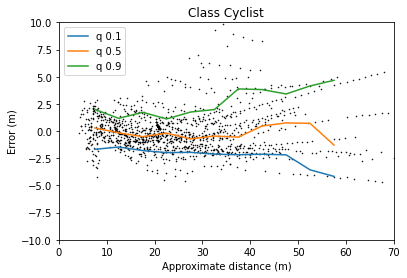

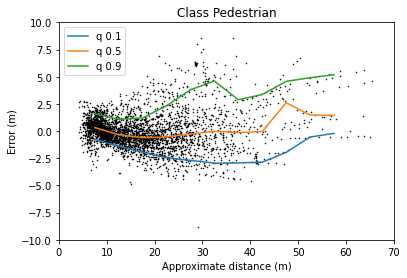

In [62]:
jump = 5
start = 5
end = 60

# Loop over classes
for class_name in ["Car","Cyclist","Pedestrian"]:
    df_train_class = df_train[df_train['type'] == class_name]
    
    # Calculate quartiles
    MDistanceE_distances = []
    for distance in range(start, end, jump):
        MDistanceE_distance = df_train_class[(distance < df_train_class['distance_ensemble4']) & \
                                           (df_train_class['distance_ensemble4'] < distance+jump)].apply(lambda row: row['distance']-row['distance_ensemble4'],
                                                                                                    axis=1).quantile(q=[0.1,0.5,0.9])
        MDistanceE_distances.append(MDistanceE_distance)
    q_0_1 = list(map(lambda x: x.get(0.1), MDistanceE_distances))
    q_0_5 = list(map(lambda x: x.get(0.5), MDistanceE_distances))
    q_0_9 = list(map(lambda x: x.get(0.9), MDistanceE_distances))

    Y = df_train_class['error_distance_ensemble4'].values
    X = df_train_class['distance_ensemble4'].values

    plt.title("Class %s" % class_name)
    plt.xlabel('Approximate distance (m)')
    plt.ylabel('Error (m)')

    plt.scatter(X, Y, s=0.3, c='black')
    
    x = np.array(list(range(start,end,jump)))+jump/2
    plt.plot(x, q_0_1)
    plt.plot(x, q_0_5)
    plt.plot(x, q_0_9)
    plt.legend(['q 0.1', 'q 0.5', 'q 0.9'])
    
    plt.xlim((0,70))
    plt.ylim((-10,10))
    
    #plt.grid(alpha=0.5)
    
    plt.show()

In [63]:
df_val['error_distance_ensemble4'].quantile(q=[0.01,0.05,0.5,0.95,0.99])

0.01   -5.140288
0.05   -3.488073
0.50   -0.268397
0.95    5.034867
0.99    9.120852
Name: error_distance_ensemble4, dtype: float64

In [64]:
df_val[df_val['distance'] < 50]['error_distance_ensemble4'].quantile(q=[0.01,0.05,0.5,0.95,0.99])

0.01   -4.814073
0.05   -3.460775
0.50   -0.371467
0.95    4.002315
0.99    7.050215
Name: error_distance_ensemble4, dtype: float64

# Save last model

In [65]:
error_model = Regression_model_error(Regression_model_class(dict_models['height_distance']['Car'],
                                                             dict_models['height_distance']['Cyclist'],
                                                             dict_models['height_distance']['Pedestrian']),
                                      Regression_model_class(dict_models['height_2d']['Car'],
                                                             dict_models['height_2d']['Cyclist'],
                                                             dict_models['height_2d']['Pedestrian']),
                                      Regression_model_class(dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car'],
                                                             dict_models['pointcloud_distance']['Car']),
                                      Regression_model_class(dict_models['pointcloud_n_points']['Car'],
                                                             dict_models['pointcloud_n_points']['Cyclist'],
                                                             dict_models['pointcloud_n_points']['Pedestrian']))

In [66]:
with open('error_model.pkl', 'wb') as f:
    f.write(pickle.dumps(error_model))